# Neural Network


The structure that is implemented is as follows: 
We will use hand written digit images from 10 classes.
The network has 2 hidden layers. First one has 200 hiddent units 
Second one has 100 hidden units

<img src = "nn.png">

#### 1. Loading Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### 2. Load MNIST Data

55000 examples for training, 5000 examples for validation and 10000 examples for testing. The digits are size normalized and centeres in a fixed size image with values from 0 to 1. Flattening is done to a 1x784 feature vector for each image. 

The data dimensions need to be specified. Number of classes as mentioned: 10.


##### 2.1 Helper Functions

Here, we'll simply write a function (load_data) which has two modes: train (which loads the training and validation images and their corresponding labels) and test (which loads the test images and their corresponding labels). You can replace this function to use your own dataset.

Other than a function for loading the images and corresponding labels, we define two more functions:

 - **randomize**: which randomizes the order of images and their labels. This is important to make sure that the input images are sorted in a completely random order. Moreover, at the beginning of each epoch, we will re-randomize the order of data samples to make sure that the trained model is not sensitive to the order of data.

 - **get_next_batch**: which only selects a few number of images determined by the batch_size variable (if you don't know why, read about Stochastic Gradient Method)

In [32]:
img_h = img_w = 28
img_size_flat = img_h * img_w
n_classes = 10
tf.reset_default_graph()

In [44]:
def load_data(mode = 'train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test


def randomize(x,y):
     """   
     Randomizes the order of data samples and their corresponding labels
     """
     perm = np.random.permutation(y.shape[0])
     shuffled_x = x[perm, :]
     shuffled_y = y[perm]
     return shuffled_x, shuffled_y


def get_next_batch(x,y,start,end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [34]:
# Load MNIST data
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print('x_train :\t{}'.format(x_train.shape))
print('y_train :\t{}'.format(y_train.shape))
print('x_valid :\t{}'.format(x_valid.shape))
print('y_valid :\t{}'.format(y_valid.shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
x_train :	(55000, 784)
y_train :	(55000, 10)
x_valid :	(5000, 784)
y_valid :	(5000, 10)


#### 3. Hyperparameters

We will be using **Stochastic Gradient Descent** that uses a small batch of images in each iteration of the optimizer. Some of the relevant terms are:

- **epoch**: One forward pass and one backward pass of all the training examples
- **Batch size**: Number of training examples in one epoch
- **Iteration**: One forward pass and one backward pass of one batch of images

Therefore, Number of iterations in an epoch = 55000/100 = 550

In [35]:
# Hyperparameters:

epochs = 10
batch_size = 100
display_freq = 100
learning_rate = 0.001

#Hidden Layer 1 units
h1 = 200

#### 3. Helper Functions to create network

##### 3.1 Creating new variables

As explained (and also illustrated in Fig. 1), we need to define two variables $\mathbf{W}$ and $\mathbf{b}$ to construt our linear model. These are generally called model parameters and as explained in our Tensor Types tutorial, we use Tensorflow Variables of proper size and initialization to define them.The following functions are written to be later used for generating the weight and bias variables of the desired shape:

In [36]:
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """    
    initer = tf.truncated_normal_initializer(stddev = 0.01)
    return tf.get_variable('W_' + name, 
                          dtype = tf.float32,
                          shape = shape,
                          initializer = initer)

def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

##### 3.2 Creating a Fully Connected Layer

Neural network consists of stacks of fully-connected (dense) layers. Having the weight ($\mathbf{W}$) and bias ($\mathbf{b}$) variables, a fully-connected layer is defined as $activation(\mathbf{W}\times \mathbf{x} + \mathbf{b})$. We define fc_layer function as follows:


In [37]:
def fc_layer(x, num_units, name, use_relu = True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.shape[1]
    W = weight_variable(name, shape=[in_dim, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x,W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

#### 4. Create Network Graph

##### 4.1 Placeholders for input and corresponding labels

Define proper tensors to feed in the input values to the model. Placeholder x is defined for the images; its data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

Next we have y which is the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is $10$ in this case.

In [38]:
# Create the graph for the linear model
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

##### 4.2 Create Network Layers

Since we have a neural network, we can stack multiple fully-connected layers using fc_layer method. Note that we will not use any activation function (use_relu=False) in the last layer. The reason is that we can use tf.nn.softmax_cross_entropy_with_logits to calculate the loss.

In [39]:
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

##### 4.3 Loss Function, Optimizer, Accuracy and Predicted Class

After creating the network, we have to calculate the loss and optimize it. Also, to evaluate our model, we have to calculate the correct_prediction and accuracy. We will also define cls_prediction to visualize our results.

In [41]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = output_logits), name = 'loss')
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, name = 'Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits,1), tf.argmax(y,1), name = 'correct_pred')

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')
cls_prediction = tf.argmax(output_logits, axis=1,name='predictions')

##### 4.4 Initialize all Variables

Invoke a variable initializer that initializes all variables


In [42]:
init = tf.global_variables_initializer()

#### 5. Train

After creating the graph, it is time to train our model. To train the model, As explained in the Graph_and_Session tutorial, we have to create a session and run the graph in our session.

In [50]:
# Creating a session 
sess = tf.InteractiveSession()

#Initialize all variables
sess.run(init)

#Number of iterations in an epoch
num_tr_iter = int(len(y_train)/ batch_size)

for epoch in range(epochs):
    print('Training epoch: ',(epoch+1))
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        start = iteration*batch_size
        end = (iteration+1)*batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)
        
        
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)
        
        if iteration % display_freq == 0:
            loss_batch, acc_batch = sess.run([loss, accuracy], feed_dict = feed_dict_batch)
            print("iteration {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}.".format(iteration, loss_batch,acc_batch))
        
    
    feed_dict_valid = {x:x_valid[:1000], y:y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss,accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
        

Training epoch:  1
iteration   0:	 Loss=2.28,	Training Accuracy=57.0%.
iteration 100:	 Loss=0.49,	Training Accuracy=81.0%.
iteration 200:	 Loss=0.42,	Training Accuracy=88.0%.
iteration 300:	 Loss=0.33,	Training Accuracy=88.0%.
iteration 400:	 Loss=0.30,	Training Accuracy=89.0%.
iteration 500:	 Loss=0.19,	Training Accuracy=94.0%.
---------------------------------------------------------
Epoch: 1, validation loss: 0.25, validation accuracy: 92.1%
---------------------------------------------------------
Training epoch:  2
iteration   0:	 Loss=0.16,	Training Accuracy=94.0%.
iteration 100:	 Loss=0.34,	Training Accuracy=87.0%.
iteration 200:	 Loss=0.12,	Training Accuracy=97.0%.
iteration 300:	 Loss=0.22,	Training Accuracy=94.0%.
iteration 400:	 Loss=0.15,	Training Accuracy=95.0%.
iteration 500:	 Loss=0.16,	Training Accuracy=97.0%.
---------------------------------------------------------
Epoch: 2, validation loss: 0.17, validation accuracy: 94.7%
--------------------------------------------

#### 6. Test

###### 6.1 Accuracy
One way that we can evaluate our model is reporting the accuracy on the test set.


In [51]:
x_test, y_test = load_data(mode = 'test')
feed_dict_test = {x:x_test[:1000],y:y_test[:1000]}
loss_test, acc_test = sess.run([loss,accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.06, test accuracy: 97.9%
---------------------------------------------------------


##### 6.2 Plotting Results

Another way to evaluate the model is to visualize the input and the model results and compare them with the true label of the input. This is advantages in numerous ways. For example, even if you get a decent accuracy, when you plot the results, you might see all the samples have been classified in one class. Another example is when you plot, you can have a rough idea on which examples your model failed. Let's define the helper functions to plot some correct and missclassified examples

###### 6.2.1 Plotting Results

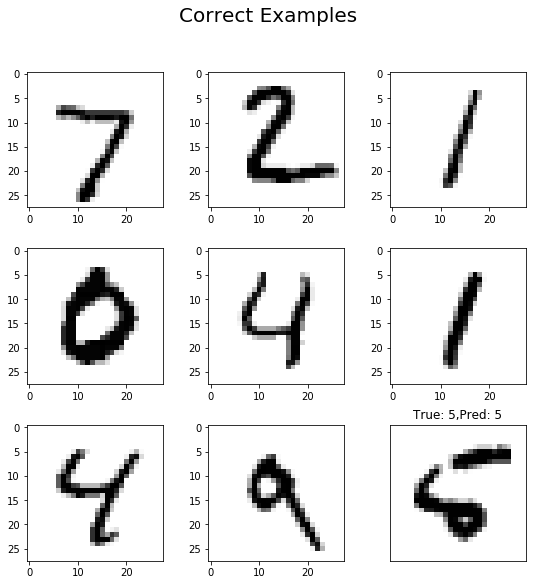

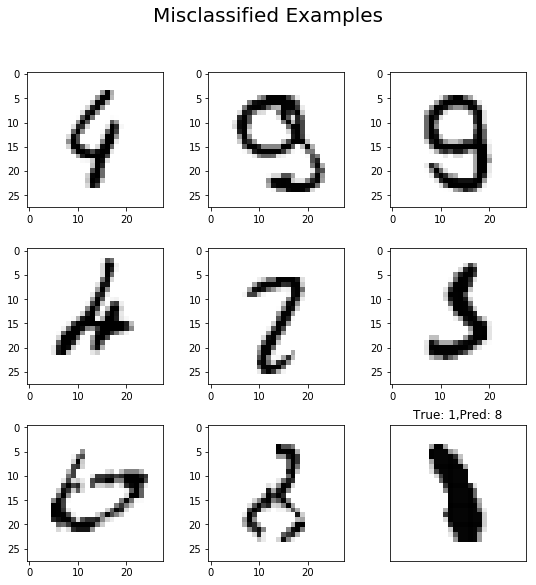

In [53]:
def plot_images(images, cls_true, cls_pred = None, title=None):
    """
    Create figure with 3x3 sub-plots.
    param images: array of images to be plotted, (9, img_h*img_w)
    param cls_true: corresponding true labels (9,)
    param cls_pred: corresponding true labels (9,)
    """
    
    fig, axes = plt.subplots(3,3, figsize =(9,9))
    fig.subplots_adjust(hspace = 0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28,28),cmap='binary')
        
    if cls_pred is None:
        ax_title = "True: {0}".format(cls_true[i])
    else:
        ax_title = "True: {0},Pred: {1}".format(cls_true[i],cls_pred[i])
        
    ax.set_title(ax_title)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)
    
    
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

    
# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test[:1000], axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true, cls_pred, title='Misclassified Examples')
plt.show()